![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Data Augmentation for Computer Vision

In the [previous notebook](01.1_bees_vs_wasps.ipynb), we explored CNNs, dropout, and padding to improve our bee vs wasp classifier. However, we still faced the challenge of **overfitting** - our model performed well on training data but struggled to generalize to new images.

**Data augmentation** is another powerful technique to combat overfitting by artificially expanding our training dataset through transformations that preserve the essential characteristics of our images while adding variety.

## What is Data Augmentation?

<img src='images/data_augmentation.png'  alt='Graphic of data augmentation, showing rotations, flips, and color changes' align=right>

Data augmentation involves applying random transformations to training images to create new, slightly different versions. For example:
- **Rotation**: Slightly rotating images
- **Flipping**: Horizontal or vertical flips
- **Scaling**: Zooming in or out
- **Color adjustments**: Changing brightness, contrast, or saturation
- **Cropping**: Taking random sections of images

These transformations help the model learn to recognize objects regardless of their orientation, lighting conditions, or position in the frame.

## Benefits of Data Augmentation

1. **Reduces overfitting**: By seeing more variations of the data
2. **Improves generalization**: Model becomes robust to variations
3. **Increases effective dataset size**: Without collecting new data
4. **Better real-world performance**: Handles variations in test conditions

Let's explore how to implement and evaluate data augmentation with our bee vs wasp dataset!

## 1. Import the libraries we will use

In [1]:
import torch
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
import random

from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

# Many functions are moved to helpers_01.py to keep this file clean.
import helpers_01

# Set seed for reproducibility
pl.seed_everything(42)

Seed set to 42


42

## 2. Check PyTorch installation

In [2]:
# Print Pytorch versions and check for GPU
print(f"Pytorch version: {torch.__version__}")
print(f'  Should be "True" if Pytorch was built for GPU: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f"  Available GPU: {torch.cuda.get_device_name()}")
else:
    print("  No GPU available, will use CPU")

Pytorch version: 2.10.0+cpu
  Should be "True" if Pytorch was built for GPU: False
  No GPU available, will use CPU


## 3. Load and prepare the data

We'll use the same subsampled bee vs wasp dataset from the previous notebook. If you need to download the data, it is [hosted for public download from HiPerGator as a `tar.gz` file](https://data.rc.ufl.edu/pub/practicum-ai/Deep_Learning_Foundations/bee_vs_wasp.tar.gz).

As before, we'll set the number of workers for Lightning data loaders.

In [3]:
# Get the data path
data_path = helpers_01.manage_data(folder_name="bee_vs_wasp_reduced")

# Set the number of workers for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

Found data at: data/bee_vs_wasp_reduced
Using 2 workers for data loading.


## 4. Exploring Data Augmentation Techniques

Before training models with augmentation, let's visualize what different augmentation techniques do to our images. This helps us understand which transformations might be beneficial for our bee vs wasp classification task.

******************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 2 workers for data loading
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------
Sample image shape: torch.Size([3, 80, 80])
Sample image label: 3


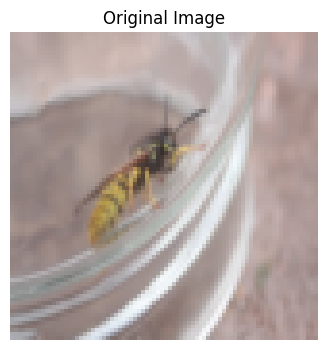

In [4]:
# First, let's load some sample images to visualize augmentations
data_module = helpers_01.load_display_data(
    data_path,
    batch_size=32,
    shape=(80, 80, 3),
    show_pictures=False,  # We'll handle visualization ourselves
    train_split=0.8,
    num_workers=num_workers,
)

# Get a sample image to demonstrate augmentations
val_loader = data_module.val_dataloader()
sample_images, sample_labels = next(iter(val_loader))
sample_image = sample_images[0]  # Take the first image

# Convert back to PIL Image for easier augmentation demonstration
# First denormalize the image
denorm_image = sample_image * torch.tensor([0.229, 0.224, 0.225]).view(
    3, 1, 1
) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
denorm_image = torch.clamp(denorm_image, 0, 1)
pil_image = to_pil_image(denorm_image)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image label: {sample_labels[0]}")

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(pil_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

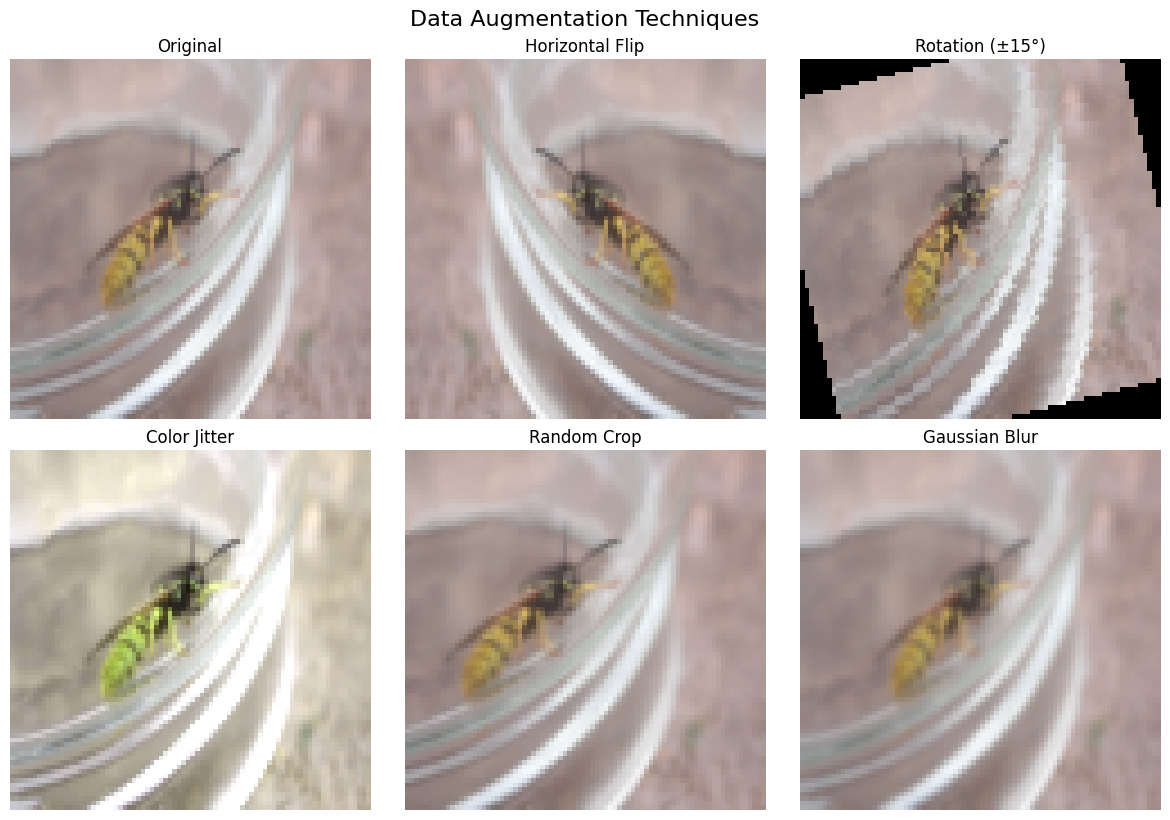

In [5]:
# Define various augmentation transforms
augmentations = {
    "Original": transforms.Compose([]),
    "Horizontal Flip": transforms.RandomHorizontalFlip(p=1.0),
    "Rotation (±15°)": transforms.RandomRotation(degrees=15),
    "Color Jitter": transforms.ColorJitter(
        brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1
    ),
    "Random Crop": transforms.RandomResizedCrop(size=(80, 80), scale=(0.8, 1.0)),
    "Gaussian Blur": transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
}

# Create a grid to show all augmentations
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, (name, transform) in enumerate(augmentations.items()):
    if name == "Original":
        aug_image = pil_image
    else:
        # Apply augmentation
        aug_image = transform(pil_image)

    axes[idx].imshow(aug_image)
    axes[idx].set_title(name)
    axes[idx].axis("off")

plt.tight_layout()
plt.suptitle("Data Augmentation Techniques", fontsize=16, y=1.02)
plt.show()

## 5. Comparing Different Augmentation Strengths

Now let's create data loaders with different levels of augmentation and see how they affect the data. We have four augmentation strengths available:

- **None**: No augmentation (baseline)
- **Light**: Basic horizontal flips and small rotations
- **Medium**: Adds color jitter and random crops
- **Heavy**: Aggressive augmentation with blur and larger transformations

One important thing to think about is how augmentations might impact the model's ability to learn about your data. For example, if you wanted a model to distinguish between 'b' and 'd', horizontal flips would be a problem! Similarly, if color is important to the categories (as it may be in our bee vs wasp example), be careful with using color jitter.

******************************************************************
Load data with augmentation:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 2 workers for data loading
  - Augmentation strength: none
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------
******************************************************************
Load data with augmentation:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3

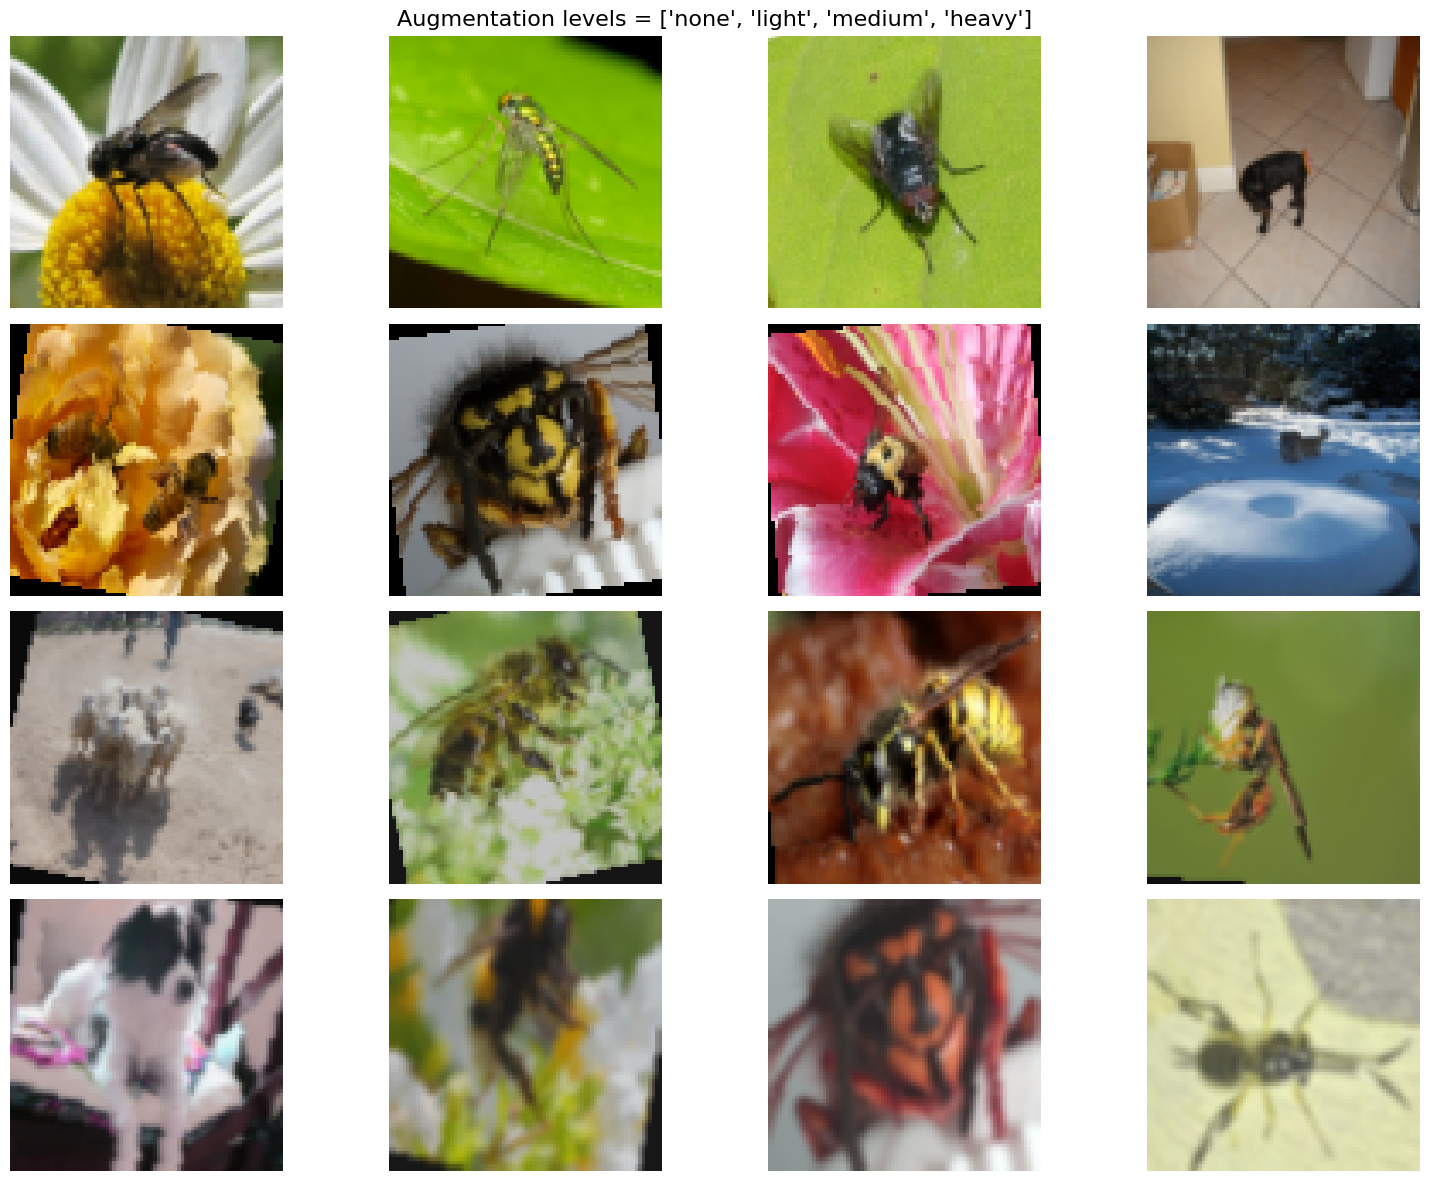

In [6]:
# Let's compare different augmentation strengths side by side
augmentation_levels = ["none", "light", "medium", "heavy"]

fig, axes = plt.subplots(len(augmentation_levels), 4, figsize=(16, 12))

for row, aug_level in enumerate(augmentation_levels):
    # Create data module with specific augmentation level
    aug_data_module = helpers_01.load_display_data_augmented(
        data_path,
        batch_size=32,
        shape=(80, 80, 3),
        show_pictures=False,
        train_split=0.8,
        num_workers=num_workers,
        augmentation_strength=aug_level,
    )

    # Get training images
    train_loader = aug_data_module.train_dataloader()
    images, labels = next(iter(train_loader))

    # Show first 4 images for this augmentation level
    for col in range(4):
        img = images[col].numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axes[row, col].imshow(img)
        if col == 0:
            axes[row, col].set_ylabel(
                f"{aug_level.title()}", fontsize=12, fontweight="bold"
            )
        axes[row, col].axis("off")

plt.suptitle("Comparison of Augmentation Strengths", fontsize=16)
plt.suptitle("Augmentation levels = ['none', 'light', 'medium', 'heavy']", fontsize=16)
plt.tight_layout()
plt.show()

## 6. Training Models with Data Augmentation

Now let's train models with different augmentation strengths and compare their performance. We'll start with a baseline model (no augmentation) and then experiment with different levels of augmentation.

TRAINING BASELINE MODEL (NO AUGMENTATION)
******************************************************************
Load data with augmentation:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 2 workers for data loading
  - Augmentation strength: none
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /workspaces/computer_vision/checkpoints exists and is not empty.

  | Name           | Type               | Params | Mode  | FLOPs
----------------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train | 0    
1 | conv2          | Conv2d             | 18.5 K | train | 0    
2 | pool           | MaxPool2d          | 0      | train | 0    
3 | dropout        | Dropout            | 0      | train | 0    
4 | relu           | ReLU               | 0      | train | 0    
5 | fc1            | Linear             

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 26/26 [00:06<00:00,  4.16it/s, v_num=1, train_loss_step=0.388, val_loss=0.909, val_acc=0.619, train_loss_epoch=0.462, train_acc=0.842]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:06<00:00,  4.16it/s, v_num=1, train_loss_step=0.388, val_loss=0.909, val_acc=0.619, train_loss_epoch=0.462, train_acc=0.842]

Baseline model evaluation:
Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00,  9.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6188119053840637
        test_loss           0.9092429280281067
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'val_loss', 'val_acc', 'epoch', 'train_loss_epoch', 'train_acc', 'train_loss_step', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: val_loss
Found val loss: val_loss with 10 points
Proce

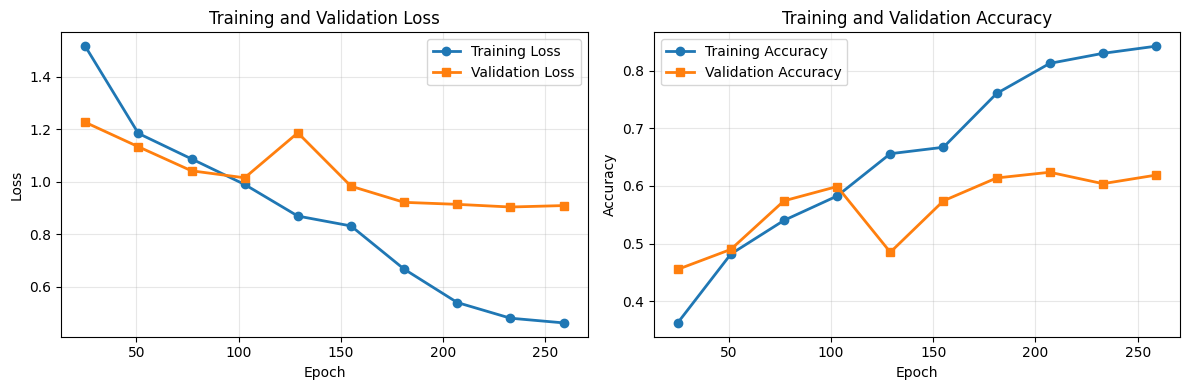

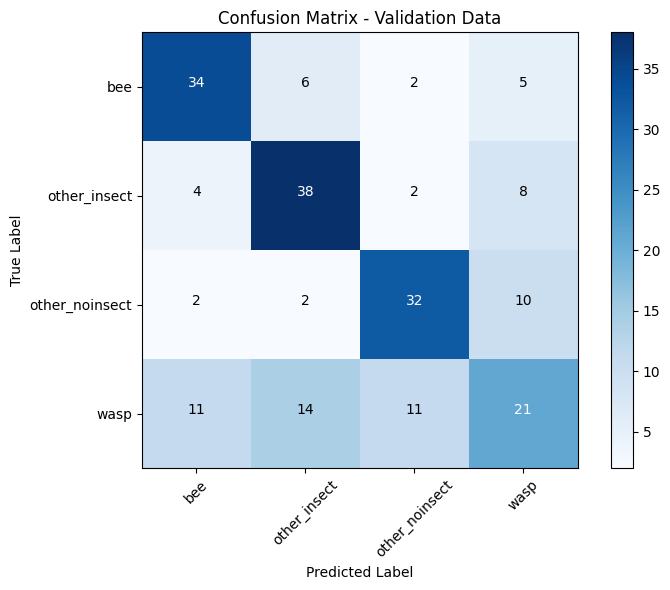


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.667, Recall=0.723, F1=0.694
   other_insect: Precision=0.633, Recall=0.731, F1=0.679
 other_noinsect: Precision=0.681, Recall=0.696, F1=0.688
           wasp: Precision=0.477, Recall=0.368, F1=0.416


In [7]:
# Step 1: Train baseline model (no augmentation)
print("=" * 60)
print("TRAINING BASELINE MODEL (NO AUGMENTATION)")
print("=" * 60)

baseline_data_module = helpers_01.load_display_data_augmented(
    data_path,
    batch_size=32,
    shape=(80, 80, 3),
    show_pictures=False,
    train_split=0.8,
    num_workers=num_workers,
    augmentation_strength="none",
)

baseline_model, baseline_trainer = helpers_01.train_model(
    data_module=baseline_data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    input_shape=(3, 80, 80),
    dropout_rate=0.3,  # Some dropout for regularization
)

print("\nBaseline model evaluation:")
baseline_results = helpers_01.test_model(
    baseline_data_module, baseline_model, baseline_trainer
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /workspaces/computer_vision/checkpoints exists and is not empty.

  | Name           | Type               | Params | Mode  | FLOPs
----------------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train | 0    
1 | conv2          | Conv2d             | 18.5 K | train | 0    
2 | pool           | MaxPool2d          | 0      | train | 0    
3 | dropout        | Dropout            | 0      | train | 0    
4 | relu           | ReLU               | 0      | train | 0    
5 | fc1            | Linear             

TRAINING MODEL WITH LIGHT AUGMENTATION
******************************************************************
Load data with augmentation:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 2 workers for data loading
  - Augmentation strength: light
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 26/26 [00:06<00:00,  3.90it/s, v_num=2, train_loss_step=1.240, val_loss=0.808, val_acc=0.658, train_loss_epoch=0.597, train_acc=0.764]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:06<00:00,  3.90it/s, v_num=2, train_loss_step=1.240, val_loss=0.808, val_acc=0.658, train_loss_epoch=0.597, train_acc=0.764]

Light augmentation model evaluation:
Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00,  9.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6584158539772034
        test_loss           0.8083656430244446
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'val_loss', 'val_acc', 'epoch', 'train_loss_epoch', 'train_acc', 'train_loss_step', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: val_loss
Found val loss: val_loss with 10 po

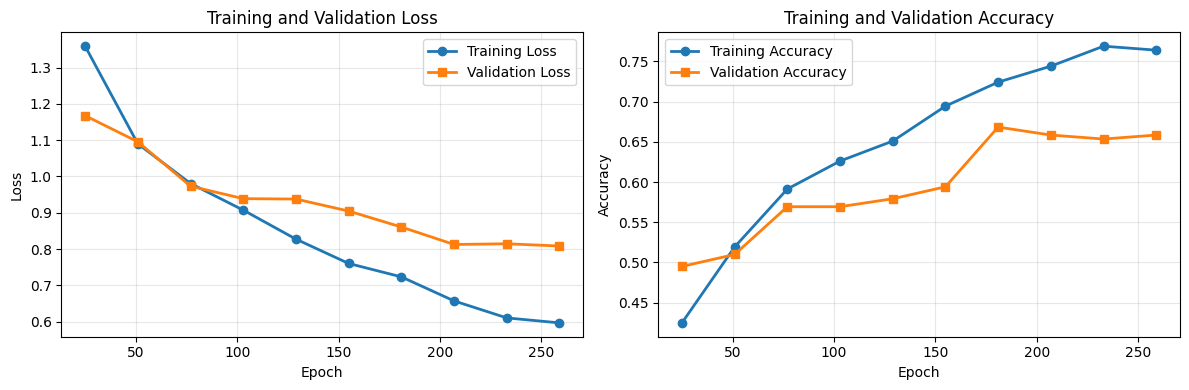

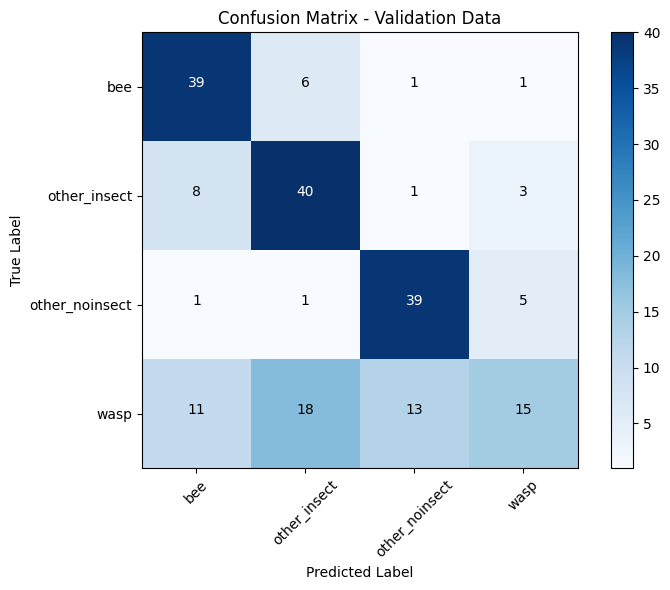


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.661, Recall=0.830, F1=0.736
   other_insect: Precision=0.615, Recall=0.769, F1=0.684
 other_noinsect: Precision=0.722, Recall=0.848, F1=0.780
           wasp: Precision=0.625, Recall=0.263, F1=0.370


In [8]:
# Step 2: Train model with light augmentation
print("=" * 60)
print("TRAINING MODEL WITH LIGHT AUGMENTATION")
print("=" * 60)

light_data_module = helpers_01.load_display_data_augmented(
    data_path,
    batch_size=32,
    shape=(80, 80, 3),
    show_pictures=False,
    train_split=0.8,
    num_workers=num_workers,
    augmentation_strength="light",
)

light_model, light_trainer = helpers_01.train_model(
    data_module=light_data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    input_shape=(3, 80, 80),
    dropout_rate=0.3,
)

print("\nLight augmentation model evaluation:")
light_results = helpers_01.test_model(light_data_module, light_model, light_trainer)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /workspaces/computer_vision/checkpoints exists and is not empty.

  | Name           | Type               | Params | Mode  | FLOPs
----------------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train | 0    
1 | conv2          | Conv2d             | 18.5 K | train | 0    
2 | pool           | MaxPool2d          | 0      | train | 0    
3 | dropout        | Dropout            | 0      | train | 0    
4 | relu           | ReLU               | 0      | train | 0    
5 | fc1            | Linear             

TRAINING MODEL WITH MEDIUM AUGMENTATION
******************************************************************
Load data with augmentation:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 2 workers for data loading
  - Augmentation strength: medium
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 26/26 [00:07<00:00,  3.65it/s, v_num=3, train_loss_step=0.528, val_loss=0.819, val_acc=0.639, train_loss_epoch=0.801, train_acc=0.677]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:07<00:00,  3.58it/s, v_num=3, train_loss_step=0.528, val_loss=0.819, val_acc=0.639, train_loss_epoch=0.801, train_acc=0.677]

Medium augmentation model evaluation:
Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00,  9.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6386138796806335
        test_loss           0.8188002109527588
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'val_loss', 'val_acc', 'epoch', 'train_loss_epoch', 'train_acc', 'train_loss_step', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: val_loss
Found val loss: val_loss with 10 p

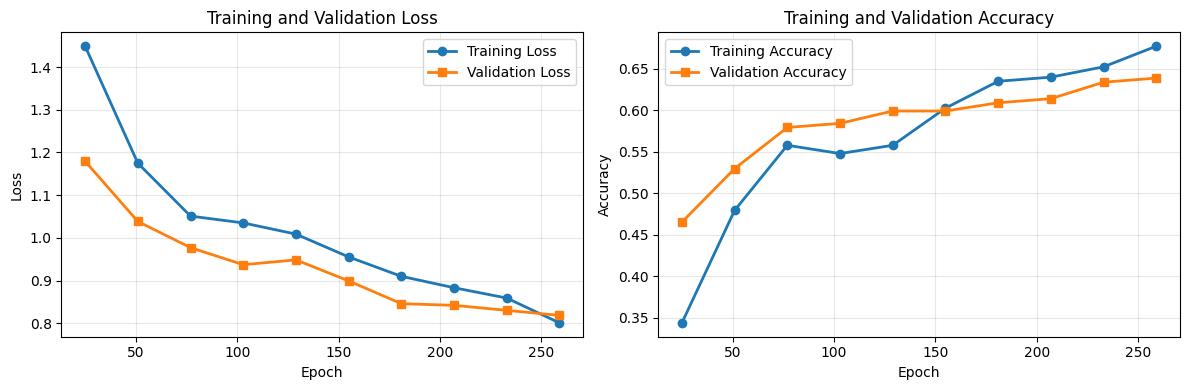

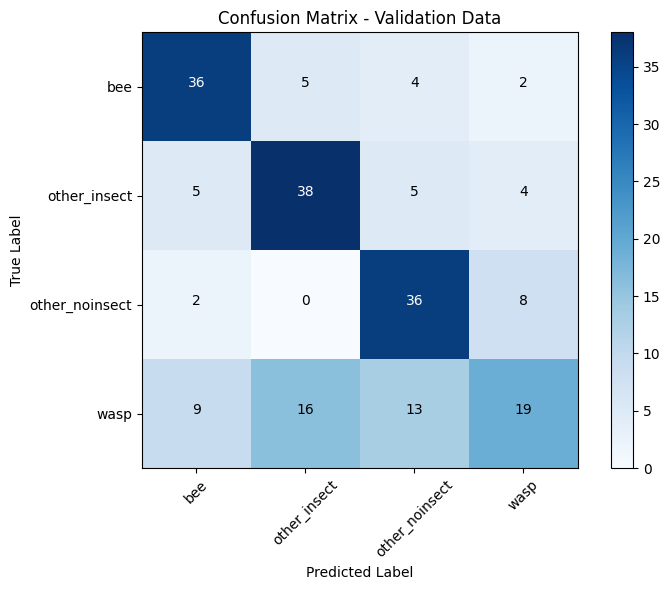


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.692, Recall=0.766, F1=0.727
   other_insect: Precision=0.644, Recall=0.731, F1=0.685
 other_noinsect: Precision=0.621, Recall=0.783, F1=0.692
           wasp: Precision=0.576, Recall=0.333, F1=0.422


In [9]:
# Step 3: Train model with medium augmentation
print("=" * 60)
print("TRAINING MODEL WITH MEDIUM AUGMENTATION")
print("=" * 60)

medium_data_module = helpers_01.load_display_data_augmented(
    data_path,
    batch_size=32,
    shape=(80, 80, 3),
    show_pictures=False,
    train_split=0.8,
    num_workers=num_workers,
    augmentation_strength="medium",
)

medium_model, medium_trainer = helpers_01.train_model(
    data_module=medium_data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    input_shape=(3, 80, 80),
    dropout_rate=0.3,
)

print("\nMedium augmentation model evaluation:")
medium_results = helpers_01.test_model(medium_data_module, medium_model, medium_trainer)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /workspaces/computer_vision/checkpoints exists and is not empty.

  | Name           | Type               | Params | Mode  | FLOPs
----------------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train | 0    
1 | conv2          | Conv2d             | 18.5 K | train | 0    
2 | pool           | MaxPool2d          | 0      | train | 0    
3 | dropout        | Dropout            | 0      | train | 0    
4 | relu           | ReLU               | 0      | train | 0    
5 | fc1            | Linear             

TRAINING MODEL WITH HEAVY AUGMENTATION
******************************************************************
Load data with augmentation:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 2 workers for data loading
  - Augmentation strength: heavy
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s, v_num=4, train_loss_step=0.637, val_loss=0.912, val_acc=0.609, train_loss_epoch=0.955, train_acc=0.607]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s, v_num=4, train_loss_step=0.637, val_loss=0.912, val_acc=0.609, train_loss_epoch=0.955, train_acc=0.607]

Heavy augmentation model evaluation:
Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 10.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6089109182357788
        test_loss           0.9115390777587891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'val_loss', 'val_acc', 'epoch', 'train_loss_epoch', 'train_acc', 'train_loss_step', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: val_loss
Found val loss: val_loss with 10 po

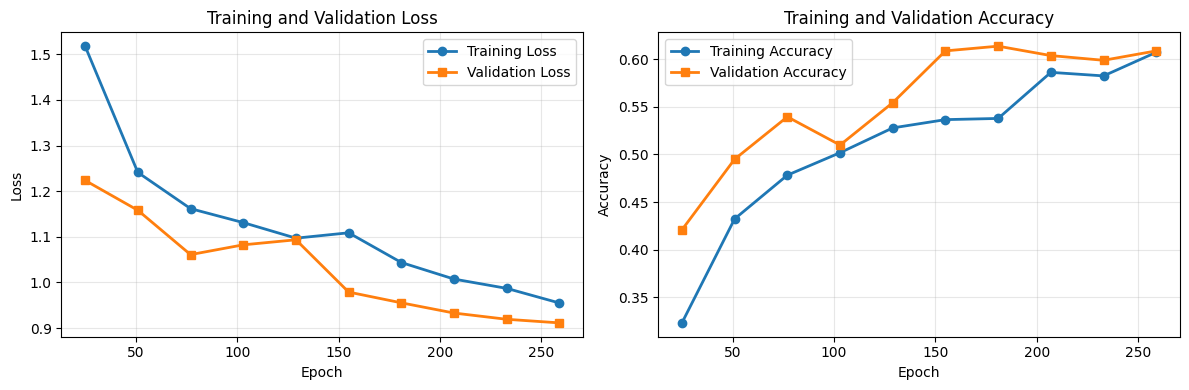

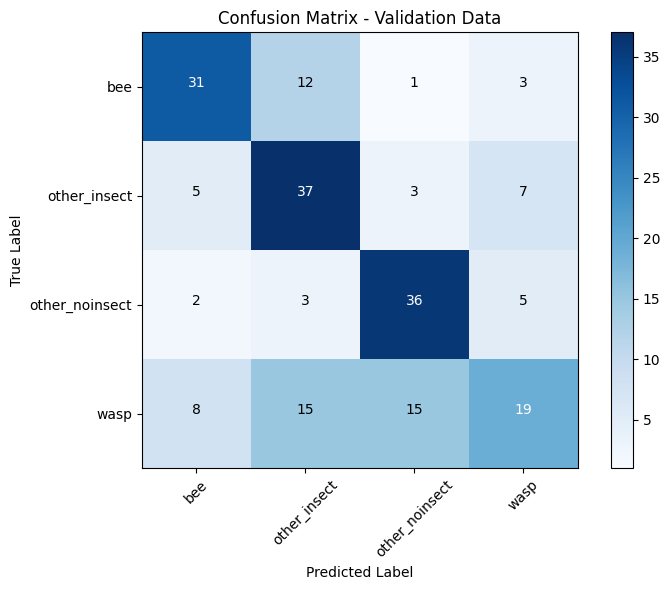


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.674, Recall=0.660, F1=0.667
   other_insect: Precision=0.552, Recall=0.712, F1=0.622
 other_noinsect: Precision=0.655, Recall=0.783, F1=0.713
           wasp: Precision=0.559, Recall=0.333, F1=0.418


In [10]:
# Step 4: Train model with heavy augmentation
print("=" * 60)
print("TRAINING MODEL WITH HEAVY AUGMENTATION")
print("=" * 60)

heavy_data_module = helpers_01.load_display_data_augmented(
    data_path,
    batch_size=32,
    shape=(80, 80, 3),
    show_pictures=False,
    train_split=0.8,
    num_workers=num_workers,
    augmentation_strength="heavy",
)

heavy_model, heavy_trainer = helpers_01.train_model(
    data_module=heavy_data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    input_shape=(3, 80, 80),
    dropout_rate=0.3,
)

print("\nHeavy augmentation model evaluation:")
heavy_results = helpers_01.test_model(heavy_data_module, heavy_model, heavy_trainer)

## 7. Comparing Results

Let's create a summary comparison of all our models to see how data augmentation affected performance.

FINAL RESULTS COMPARISON
Model                Test Accuracy  
-----------------------------------
Baseline (No Aug)    0.619          
Light Augmentation   0.658          
Medium Augmentation  0.639          
Heavy Augmentation   0.609          


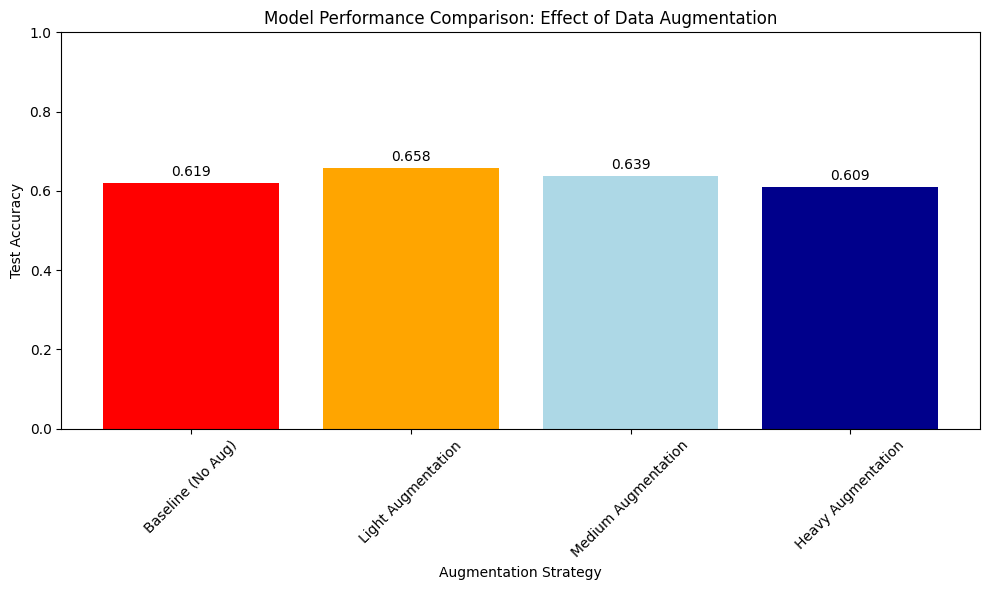

In [11]:
# Extract test accuracy from each model
models_summary = {
    "Baseline (No Aug)": baseline_results[0]["test_acc"],
    "Light Augmentation": light_results[0]["test_acc"],
    "Medium Augmentation": medium_results[0]["test_acc"],
    "Heavy Augmentation": heavy_results[0]["test_acc"],
}

print("=" * 50)
print("FINAL RESULTS COMPARISON")
print("=" * 50)
print(f"{'Model':<20} {'Test Accuracy':<15}")
print("-" * 35)

for model_name, accuracy in models_summary.items():
    print(f"{model_name:<20} {accuracy:<15.3f}")

# Create a bar plot comparing accuracies
plt.figure(figsize=(10, 6))
model_names = list(models_summary.keys())
accuracies = list(models_summary.values())

bars = plt.bar(
    model_names, accuracies, color=["red", "orange", "lightblue", "darkblue"]
)
plt.title("Model Performance Comparison: Effect of Data Augmentation")
plt.ylabel("Test Accuracy")
plt.xlabel("Augmentation Strategy")
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{acc:.3f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

### KEY OBSERVATIONS:

1. Compare validation vs training accuracy in each model's plots above
2. Look for reduced overfitting with augmentation (smaller gap between train/val)
3. Optimal augmentation level balances regularization without hurting performance
4. Heavy augmentation might hurt performance if it's too aggressive
5. Data augmentation is most effective when you have limited training data

## 8. Conclusion and Best Practices

### What We Learned About Data Augmentation:

1. **Reduces Overfitting**: Data augmentation helps models generalize better by exposing them to variations of the training data.

2. **Augmentation Strength Matters**: 
   - **Light** augmentation often provides good benefits with minimal risk
   - **Medium** augmentation can be very effective for most datasets
   - **Heavy** augmentation may hurt performance if too aggressive

3. **Dataset Size Impact**: Data augmentation is most beneficial when you have limited training data.

4. **Training Time**: Models with augmentation may take longer to converge since they see more varied data.

### Best Practices for Data Augmentation:

- **Start with light augmentation** and gradually increase if needed
- **Preserve class semantics** - don't apply transformations that change the class
- **Use domain knowledge** - apply transformations that make sense for your data
- **Monitor overfitting** - augmentation should reduce the train/validation gap
- **Experiment systematically** - try different combinations and strengths

### When to Use Data Augmentation:

✅ **Good for:**
- Small datasets
- High overfitting
- Need for robustness
- Computer vision tasks

❌ **Be careful with:**
- Already large datasets
- Time-sensitive applications
- Tasks where transformations change meaning

Data augmentation is a powerful tool in the computer vision toolkit. Combined with other regularization techniques like dropout, it can significantly improve model performance and generalization!

----
## Push changes to GitHub <img src="images/push_to_github.png" alt="Push to GitHub icon" align="right" width=150>

 Remember to **add**, **commit**, and **push** the changes you have made to this notebook to GitHub to keep your repository in sync.

In Jupyter, those are done in the git tab on the left. In Google Colab, use File > Save a copy in GitHub.